In [1]:
import sys
import os
BASE_PATH = './../dynaphos-core/'
sys.path.append(BASE_PATH)

import time

import cv2
import numpy as np
import torch

from dynaphos.image_processing import sobel_processor, canny_processor
from dynaphos.simulator import GaussianSimulator
from dynaphos.utils import load_params, load_coordinates_from_yaml, Map
from dynaphos.cortex_models import \
    get_visual_field_coordinates_from_cortex_full

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
params = load_params('../dynaphos-core/config/params.yaml')

In [3]:
params['thresholding']['use_threshold'] = False
coordinates_cortex = load_coordinates_from_yaml(
    '../dynaphos-core/config/grid_coords_dipole_valid.yaml', n_coordinates=1000)
coordinates_cortex = Map(*coordinates_cortex)
coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(
    params['cortex_model'], coordinates_cortex)
simulator = GaussianSimulator(params, coordinates_visual_field)
resolution = params['run']['resolution']
fps = params['run']['fps']

device='cuda:0'

In [4]:
fps

100

In [20]:
import scipy.io

subject = 'jw'
image_id = 'i1485351340' #deer
image_id = 'i1169220553' #bacon
# image_id = 'i05june05_static_street_boston_p1010764'#street
# image_id = 'i1260655983' #SLJ
# image_id = 'i1344739819' #woman

image = cv2.imread(f'../../EyetrackingDatabaseFolder/ALLSTIMULI/{image_id}.jpeg') 
mat = scipy.io.loadmat(f'../../EyetrackingDataBaseFolder/DATA/{subject}/{image_id}.mat')
eye_data = mat[image_id]['DATA'][0][0][0][0][2]

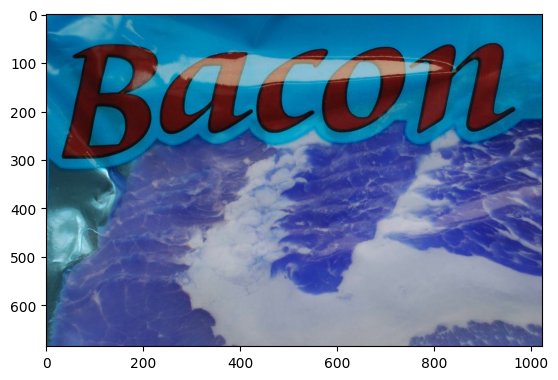

In [21]:
fig, axs = plt.subplots()
# axs.axis('off')
axs.imshow(image)

1024 685
(685, 2)


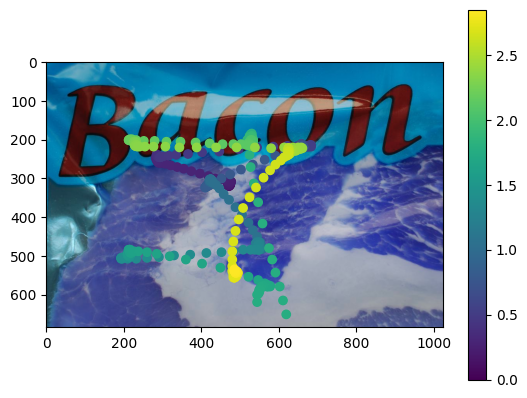

In [22]:
y_res, x_res = image.shape[:2]
print(x_res, y_res)

eye_data = eye_data[(eye_data[:,0]>=0) & (eye_data[:,0]<x_res) & (eye_data[:,1]>=0) & (eye_data[:,1]<y_res)]
print(eye_data.shape)
plt.figure()

implot = plt.imshow(image)
plt.scatter(eye_data[:,0],eye_data[:,1], c=np.arange(eye_data.shape[0])/240)
plt.colorbar()
plt.show()

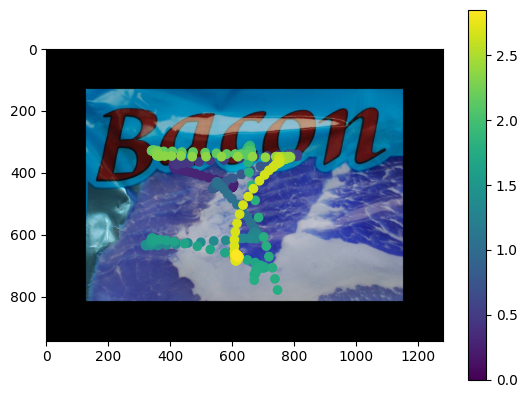

In [23]:
x_offset = resolution[0]//2
y_offset = resolution[1]//2

image_sub = np.zeros((image.shape[0]+resolution[0]+2,image.shape[1]+resolution[1]+2,3), dtype=int)
image_sub[x_offset+1:-x_offset-1, y_offset+1:-y_offset-1] = image

eye_data_sub = eye_data.copy()
eye_data_sub[:,0] += x_offset
eye_data_sub[:,1] += y_offset

implot = plt.imshow(image_sub)
plt.scatter(eye_data_sub[:,0],eye_data_sub[:,1], c=np.arange(eye_data.shape[0])/240)
plt.colorbar()
plt.show()

In [24]:
n_frames = len(eye_data)
frames = np.zeros((n_frames,resolution[0],resolution[1],3), dtype=np.float32)
print(image_sub.shape)
for i in tqdm(range(n_frames)):
    x_offset = resolution[0]//2
    y_offset = resolution[1]//2
    pos = eye_data_sub[i].astype(int)
    frames[i] = image_sub[pos[1] - y_offset:pos[1] + y_offset, pos[0] - x_offset:pos[0] + x_offset]
    # frames[i] = frames[i]/255

(943, 1282, 3)


100%|██████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 7048.61it/s]


In [25]:
size = image_sub.shape[0],image_sub.shape[1]
print(frames.shape, size)
frame_recon = np.zeros((n_frames,image_sub.shape[0],image_sub.shape[1],3))
# duration = 2
fps = fps
out = cv2.VideoWriter(f'eye_tracked_{image_id}_subject_{subject}_orig.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), True)
for i in range(n_frames):
    pos = eye_data_sub[i].astype(int)
    frame_recon[i,pos[1] - y_offset:pos[1] + y_offset, pos[0] - x_offset:pos[0] + x_offset] = frames[i]
    data = frame_recon[i].astype('uint8') #np.random.randint(0, 256, size, dtype='uint8')
    out.write(data)
out.release()

(685, 256, 256, 3) (943, 1282)


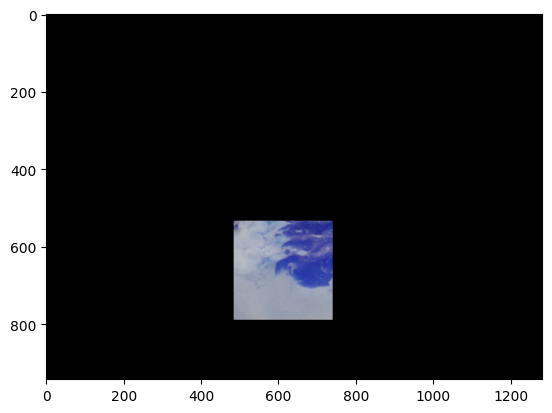

In [26]:
plt.imshow(frame_recon[-1]/255)#frames[-1])

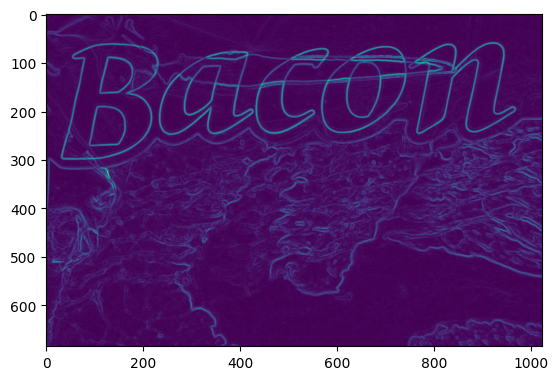

In [27]:
test_filter_image = image.astype('uint8')
test_filter_image = cv2.cvtColor(test_filter_image, cv2.COLOR_BGR2GRAY)
test_filter_image = cv2.GaussianBlur(test_filter_image, (3, 3), 0)

method = 'sobel'#params['sampling']['filter']
if method == 'sobel':
    test_filter_image = sobel_processor(test_filter_image)
elif method == 'canny':
    threshold = 200
    test_filter_image = canny_processor(test_filter_image, threshold // 2,
                                    threshold)
elif method == 'none':
    test_filter_image = test_filter_image
    
plt.imshow(test_filter_image)

In [28]:
sim_frames = np.zeros((n_frames,resolution[0],resolution[1]))
proc_images = np.zeros((n_frames,resolution[0],resolution[1]))
for i, frame in enumerate(tqdm(frames)):
    frame = frame.astype('uint8')
    frame = cv2.resize(frame, resolution)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (3, 3), 0)
    
    method = 'canny'#'canny'#params['sampling']['filter']
    if method == 'sobel':
        processed_img = sobel_processor(frame)
    elif method == 'canny':
        threshold = 200#params['sampling']['T_high']
        processed_img = canny_processor(frame, threshold // 2,
                                        threshold)
    elif method == 'none':
        processed_img = frame
    else:
        raise ValueError(f"{method} is not a valid filter keyword.")
    
    proc_images[i] = processed_img
    # Generate phosphenes
    stim_pattern = simulator.sample_receptive_fields(torch.from_numpy(processed_img/255).to(device))
    # print(stim_pattern)
    stim_pattern = stim_pattern*(10**-(4))
    #print(stim_pattern)
    phosphenes = simulator(stim_pattern)
    phosphenes = phosphenes.cpu().numpy()
    
    sim_frames[i] = phosphenes

100%|████████████████████████████████████████████████████████████████████████████████| 685/685 [00:39<00:00, 17.25it/s]


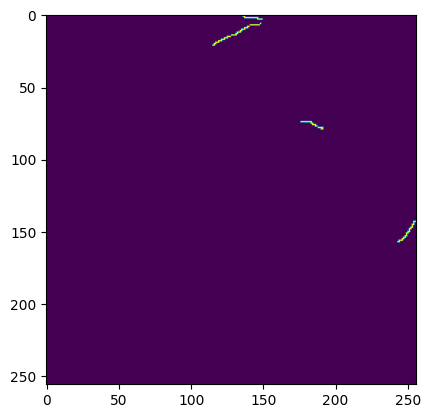

In [29]:
plt.imshow(proc_images[-2])

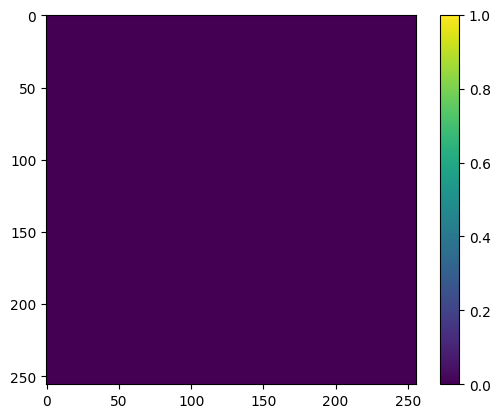

In [30]:
# simulator.reset()
plt.imshow(sim_frames[-2],vmin=0,vmax=1)
plt.colorbar()

In [31]:
sim_vid_sub = np.zeros((n_frames,image_sub.shape[0],image_sub.shape[1]))
print(sim_vid_sub.shape)
for i in tqdm(range(n_frames)):
    pos = eye_data_sub[i].astype(int)
    sim_vid_sub[i,pos[1] - y_offset:pos[1] + y_offset, pos[0] - x_offset:pos[0] + x_offset] = sim_frames[i]
    
#remove border
sim_vid = sim_vid_sub[:,x_offset+1:-x_offset-1, y_offset+1:-y_offset-1]*255

(685, 943, 1282)


100%|██████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 2215.79it/s]


In [32]:
proc_vid_sub = np.zeros((n_frames,image_sub.shape[0],image_sub.shape[1]))
print(sim_vid_sub.shape)
for i in tqdm(range(n_frames)):
    pos = eye_data_sub[i].astype(int)
    proc_vid_sub[i,pos[1] - y_offset:pos[1] + y_offset, pos[0] - x_offset:pos[0] + x_offset] = proc_images[i]
    
#remove border
proc_vid = proc_vid_sub[:,x_offset+1:-x_offset-1, y_offset+1:-y_offset-1]#*255

(685, 943, 1282)


100%|███████████████████████████████████████████████████████████████████████████████| 685/685 [00:01<00:00, 569.57it/s]


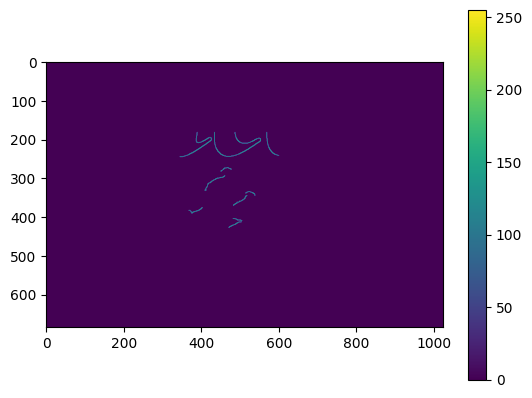

In [33]:
plt.imshow(proc_vid[0])
# plt.scatter(eye_data[:,0],eye_data[:,1], c=np.arange(eye_data.shape[0])/240,cmap='gray')
plt.colorbar()

In [34]:
#write to video
# sim_vid = sim_vid.swapaxes(1,2)
size = y_res, x_res
print(sim_vid.shape, size)
# duration = 2
fps = 25#fps
out = cv2.VideoWriter(f'eye_tracked_{image_id}_subject_{subject}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
out2 = cv2.VideoWriter(f'eye_tracked_{image_id}_subject_{subject}_processed.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
for i in range(n_frames):
    data = sim_vid[i].astype('uint8') #np.random.randint(0, 256, size, dtype='uint8')
    out.write(data)
    data = proc_vid[i].astype('uint8')
    out2.write(data)
out.release()
out2.release()

(685, 685, 1024) (685, 1024)
